<a href="https://colab.research.google.com/github/rafio-iut/Vegetable-Classification-and-Quality-Assessment/blob/main/Vegetable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import Subset
from torch.utils.data import ConcatDataset
import torch.optim as optim
import torchvision
from torchvision import models, transforms
from torchsummary import summary

import math
import time
import random
import os
import shutil
import copy

# Initialize Environment

## Setup GPU

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Clone Repository and Setup Environment

In [3]:
!rm -r *

!git clone https://github.com/rafio-iut/Vegetable-Classification-and-Quality-Assessment.git

!mv Vegetable-Classification-and-Quality-Assessment/* .

!rm -r Vegetable-Classification-and-Quality-Assessment

Cloning into 'Vegetable-Classification-and-Quality-Assessment'...
remote: Enumerating objects: 6199, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 6199 (delta 9), reused 17 (delta 6), pack-reused 6176
Receiving objects: 100% (6199/6199), 121.47 MiB | 8.12 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Updating files: 100% (6154/6154), done.


# Load Data

## Explode Directories

In [4]:
root_dir = '/content/New VegNet'

for folder_name in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder_name)

    if os.path.isdir(folder_path):
        for subfolder_name in os.listdir(folder_path):
            subfolder_path = os.path.join(folder_path, subfolder_name)

            if os.path.isdir(subfolder_path):
                new_folder_name = folder_name + ' - ' + subfolder_name
                new_folder_name = new_folder_name.split('. ')[1]
                new_folder_path = os.path.join(root_dir, new_folder_name)

                os.makedirs(new_folder_path, exist_ok=True)

                for file_name in os.listdir(subfolder_path):
                    file_path = os.path.join(subfolder_path, file_name)
                    new_file_path = os.path.join(new_folder_path, file_name)
                    shutil.move(file_path, new_file_path)

                os.rmdir(subfolder_path)

## Delete Empty Folders

In [5]:
root_dir = '/content/New VegNet'
for root, dirs, files in os.walk(root_dir, topdown=False):
        for folder in dirs:
            folder_path = os.path.join(root, folder)
            if not os.listdir(folder_path):
                os.rmdir(folder_path)

## Load Raw Dataset

In [6]:
root_dir = '/content/New VegNet'

raw_dataset = torchvision.datasets.ImageFolder(root=root_dir, transform=transforms.ToTensor())
labels = raw_dataset.classes

# Shuffle Dataset

In [7]:
num_samples = len(raw_dataset)
random_state = 129

shuffle_indices = list(range(num_samples))
random.Random(random_state).shuffle(shuffle_indices)
print(shuffle_indices[:10])

raw_dataset = Subset(raw_dataset, shuffle_indices)

[5627, 5920, 4985, 4091, 1999, 168, 3480, 3095, 4431, 397]


# Display Dataset

## Utility Functions

In [8]:
def parse_label(label):
    words = label.split(" - ")
    if len(words) < 2:
        return None, None
    vegetable = words[0].strip()
    quality = words[1].strip()
    return vegetable, quality

def get_label_counts(dataset):
    targets = [target for _, target in dataset]

    counts = {}
    for target in targets:
        label = labels[target]
        if label in counts: counts[label] += 1
        else: counts[label] = 1

    return dict(sorted(counts.items()))

def get_label_images(dataset):
    images = {}
    for image, target in dataset:
        label = labels[target]
        if label not in images:
            images[label] = image
            if len(images) == len(labels): return dict(sorted(images.items()))

    return dict(sorted(images.items()))

In [9]:
def display_counts(dataset, dataset_name):
    class_counts = get_label_counts(dataset)

    vegetables = []
    qualities = []
    for label in class_counts.keys():
        vegetable, quality = parse_label(label)
        if vegetable not in vegetables:
            vegetables.append(vegetable)
        if quality not in qualities:
            qualities.append(quality)

    df_table = pd.DataFrame(index=sorted(vegetables), columns=sorted(qualities))
    df_table.fillna(0, inplace=True)

    for label, count in class_counts.items():
        vegetable, quality = parse_label(label)
        df_table.loc[vegetable, quality] = count

    df_table.loc['Total'] = df_table.sum()
    df_table['Total'] = df_table.sum(axis=1)

    print(dataset_name)
    display(df_table)
    print()

In [10]:
def display_images(dataset):
    label_images = get_label_images(dataset)

    num_classes = len(label_images)
    num_cols = 5
    num_rows = math.ceil(num_classes / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4*num_rows))

    for i, (label, image) in enumerate(label_images.items()):
        row = i // num_cols
        col = i % num_cols

        image = image.numpy().transpose(1, 2, 0)
        vegetable, quality = parse_label(label)

        ax = axes[row, col] if num_rows > 1 else axes[col]
        ax.imshow(image)
        ax.set_title(vegetable, fontsize=12, fontweight='bold', pad=10)
        ax.axis('off')
        ax.text(0.5, -0.075, quality, transform=ax.transAxes, ha='center', fontsize=12)

    for i in range(len(label_images), num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols

        ax = axes[row, col] if num_rows > 1 else axes[col]
        ax.axis('off')

    plt.tight_layout(h_pad=2)
    plt.show()

## Display Counts

In [11]:
display_counts(raw_dataset, 'Raw Dataset')

Raw Dataset


,Damaged,Dried,Old,Ripe,Unripe,Total
Bell Pepper,31,296,349,448,52,1176
Chile Pepper,121,593,200,183,189,1286
New Mexico Green Chile,138,500,261,201,227,1327
Tomato,27,0,1234,955,145,2361
Total,317,1389,2044,1787,613,6150


## Display Images

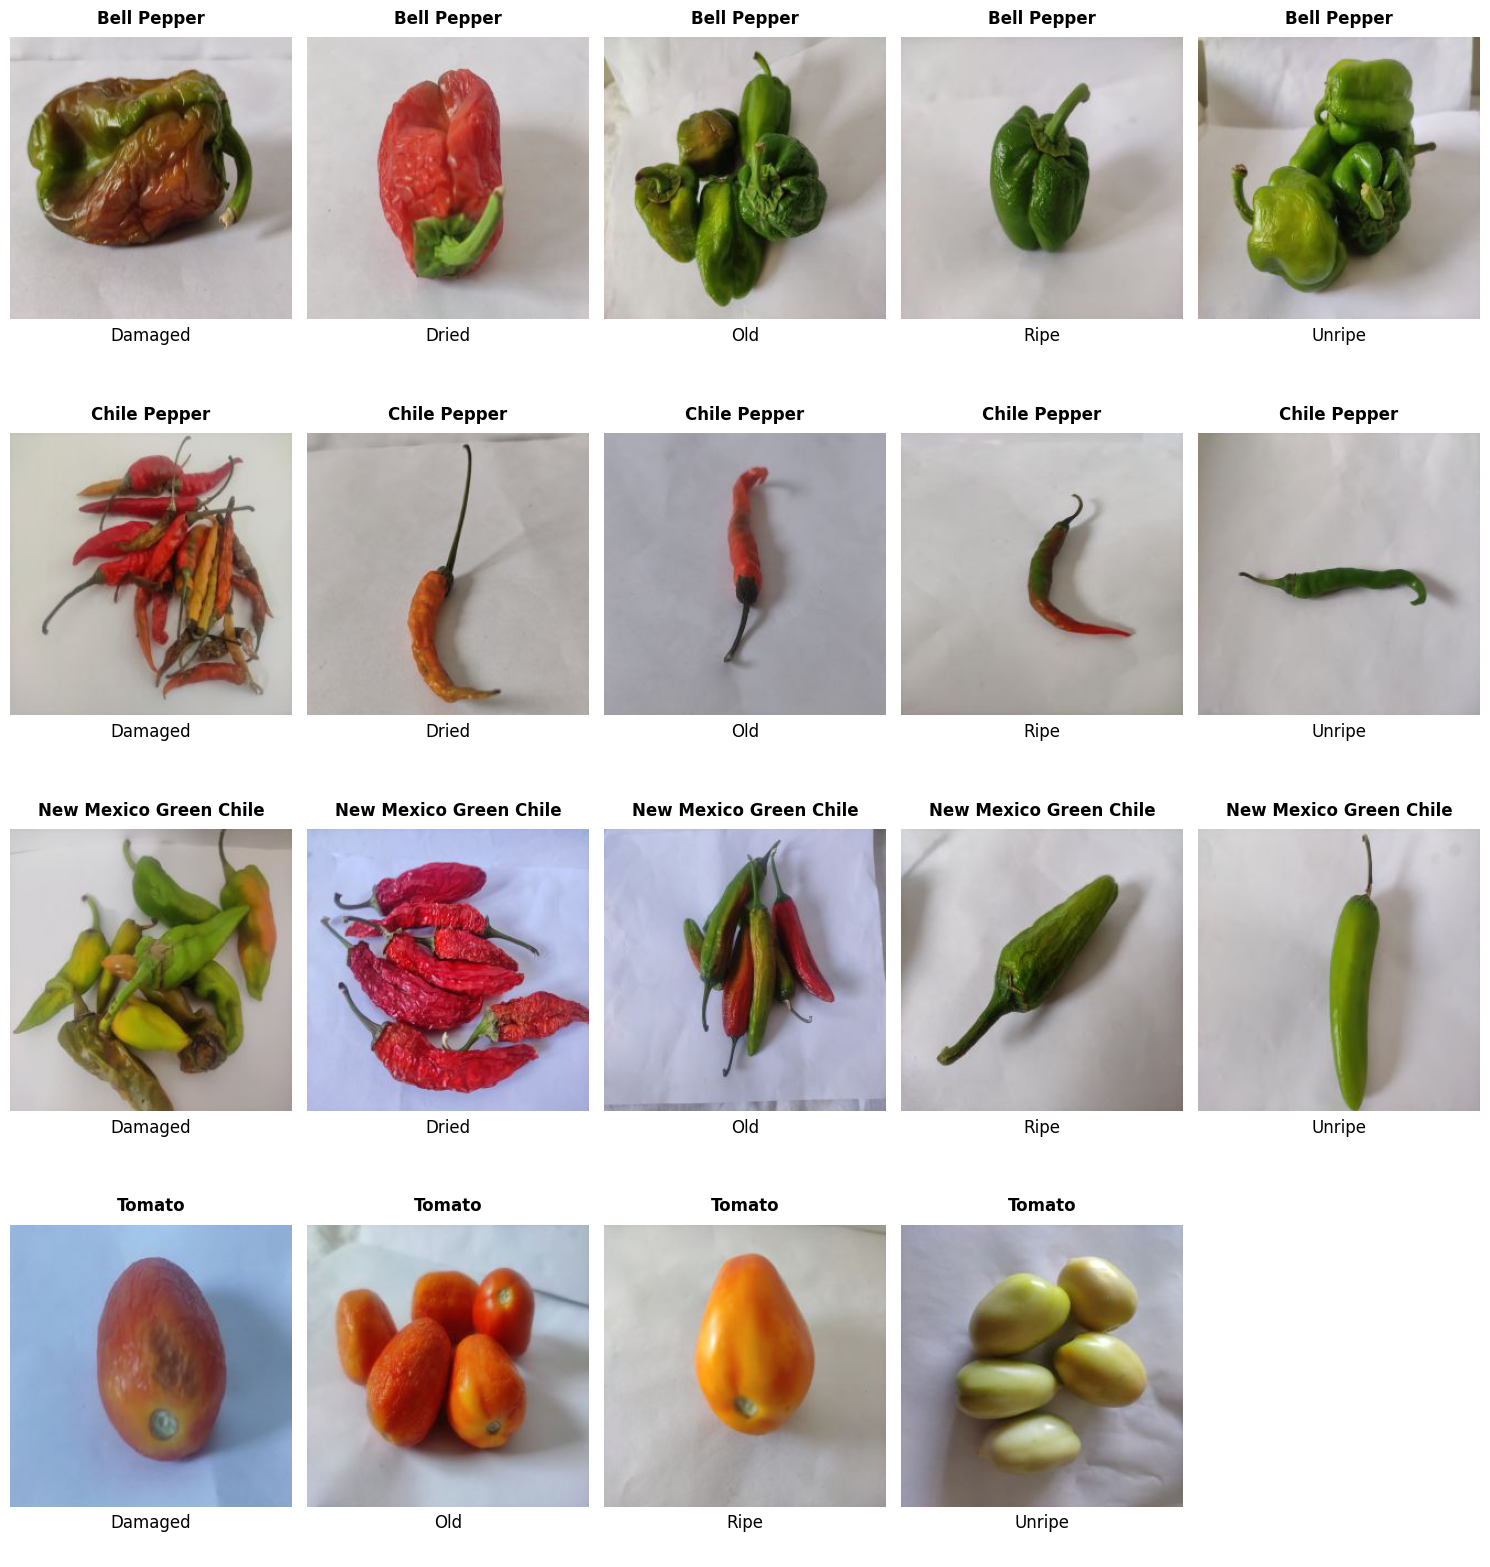

In [12]:
display_images(raw_dataset)

# Data Transformation

## Define Transformations

In [13]:
transformations = [
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=10, fill=0),
    transforms.ToTensor()
]

## Create Transformed Dataset

In [14]:
# transformed_dataset = raw_dataset
# transformed_dataset.transform = transforms.Compose(transformations)
# transformed_dataset = ConcatDataset([Subset(transformed_dataset, shuffle_indices), raw_dataset])

root_dir = '/content/New VegNet'
transformed_dataset = ConcatDataset([
    Subset(
        torchvision.datasets.ImageFolder(
            root=root_dir,
            transform=transforms.Compose(transformations)
        ),
        shuffle_indices
    ),
    raw_dataset
])

## Display Dataset

Transformed Dataset


,Damaged,Dried,Old,Ripe,Unripe,Total
Bell Pepper,62,592,698,896,104,2352
Chile Pepper,242,1186,400,366,378,2572
New Mexico Green Chile,276,1000,522,402,454,2654
Tomato,54,0,2468,1910,290,4722
Total,634,2778,4088,3574,1226,12300


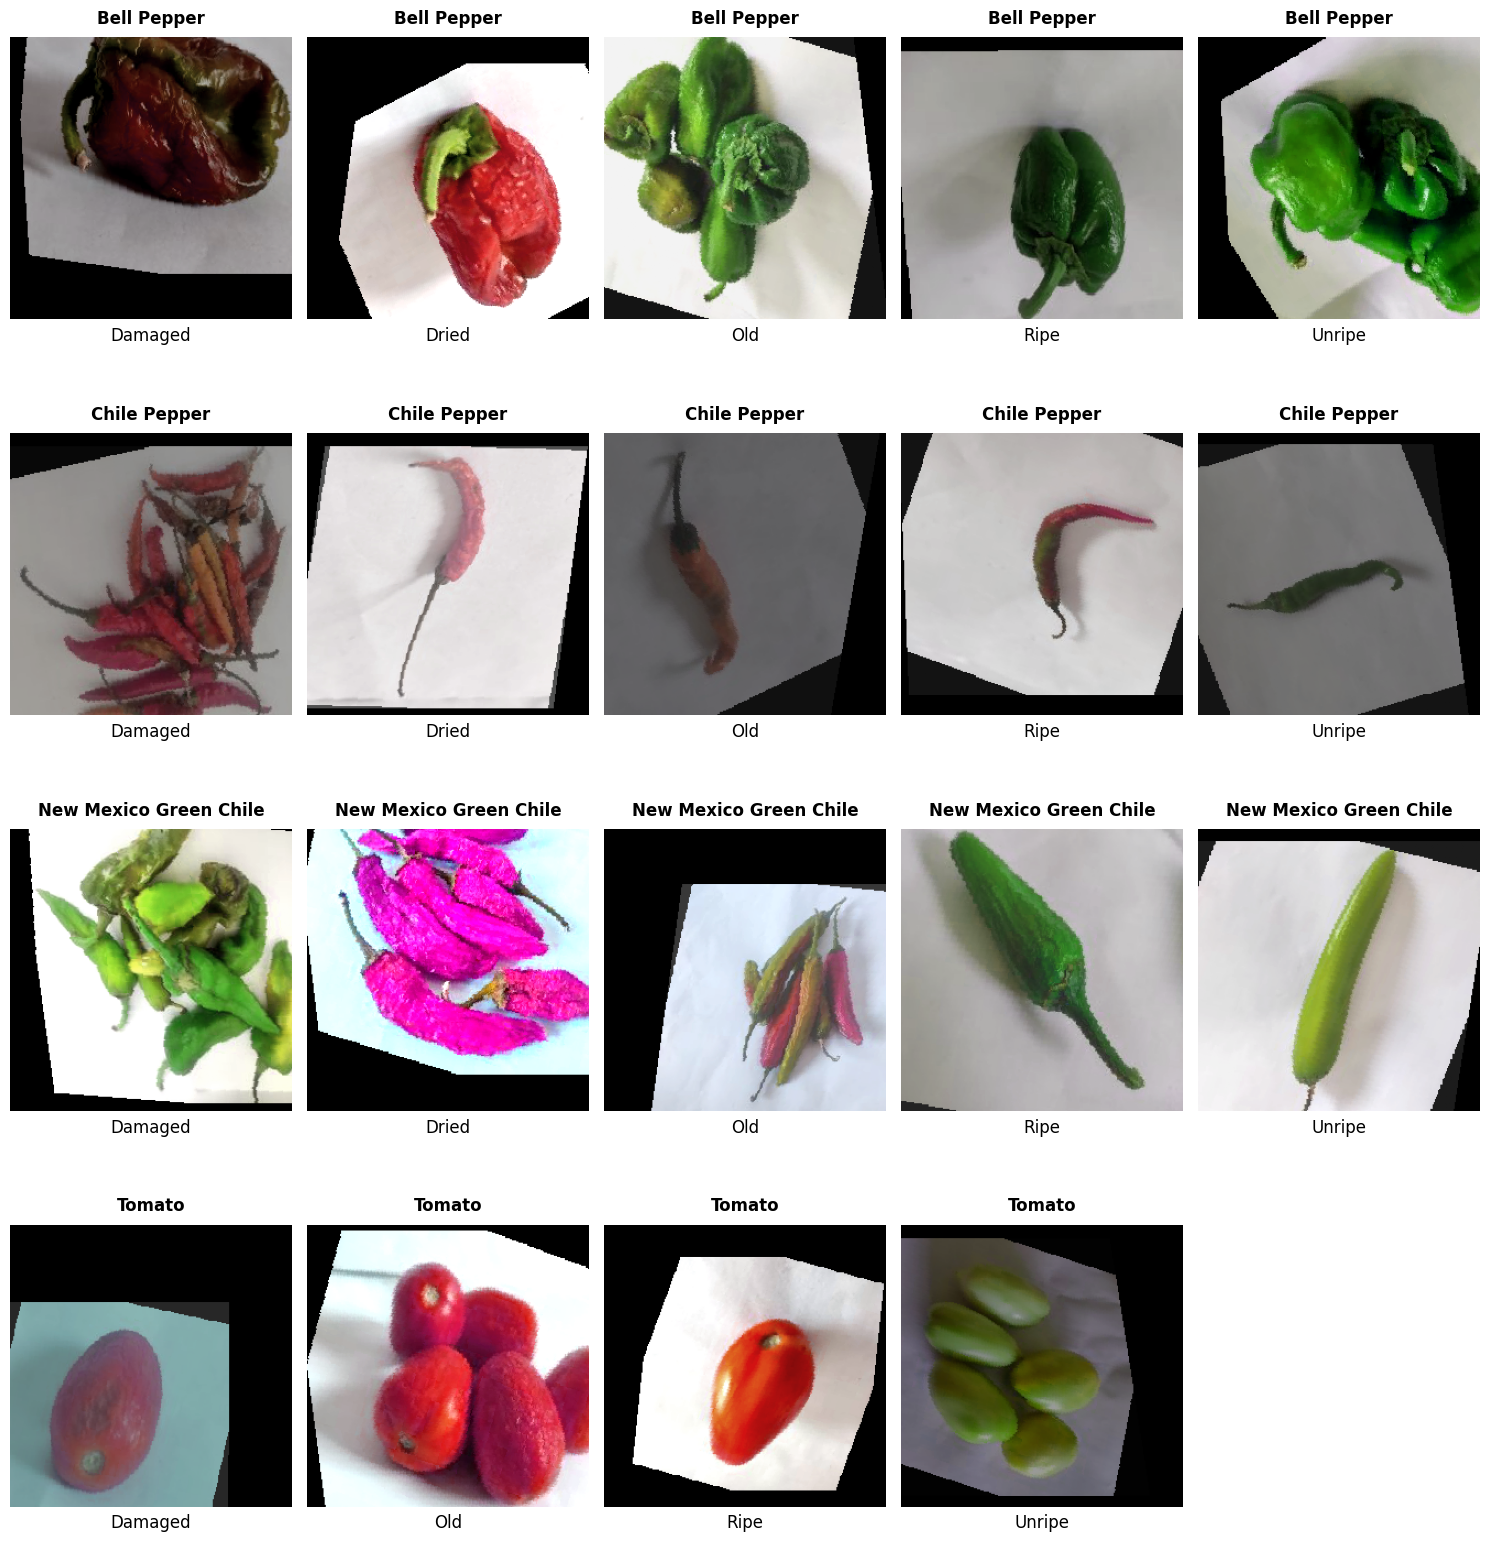

In [15]:
display_counts(transformed_dataset, 'Transformed Dataset')
display_images(transformed_dataset)

## K-Fold Cross Validation

In [16]:
targets = [target for _, target in transformed_dataset]

k = 5
c = len(labels)

class_subsets = [[] for _ in range(c)]
for idx, target in enumerate(targets): class_subsets[target].append(idx)

subset_indices = [[] for _ in range(k)]

for class_subset in class_subsets:
    random.shuffle(class_subset)
    subset_size = len(class_subset) // k
    leftover_samples = len(class_subset) % k

    for i in range(k):
        start_idx = i * subset_size
        end_idx = (i + 1) * subset_size
        subset_indices[i].extend(class_subset[start_idx:end_idx])

    random.shuffle(class_subset)
    for i in range(leftover_samples):
        subset_indices[i].append(class_subset[i])
    random.shuffle(class_subset)

datasubset = []
for indices in subset_indices:
    subset = Subset(transformed_dataset, indices)
    datasubset.append(subset)

for i, subset in enumerate(datasubset): display_counts(subset, f'Subset {i+1}')

Subset 1


,Damaged,Dried,Old,Ripe,Unripe,Total
Bell Pepper,13,119,140,180,21,473
Chile Pepper,49,238,80,74,76,517
New Mexico Green Chile,56,200,105,81,91,533
Tomato,11,0,494,382,58,945
Total,129,557,819,717,246,2468



Subset 2


,Damaged,Dried,Old,Ripe,Unripe,Total
Bell Pepper,13,119,140,179,21,472
Chile Pepper,49,237,80,73,76,515
New Mexico Green Chile,55,200,105,81,91,532
Tomato,11,0,494,382,58,945
Total,128,556,819,715,246,2464



Subset 3


,Damaged,Dried,Old,Ripe,Unripe,Total
Bell Pepper,12,118,140,179,21,470
Chile Pepper,48,237,80,73,76,514
New Mexico Green Chile,55,200,104,80,91,530
Tomato,11,0,494,382,58,945
Total,126,555,818,714,246,2459



Subset 4


,Damaged,Dried,Old,Ripe,Unripe,Total
Bell Pepper,12,118,139,179,21,469
Chile Pepper,48,237,80,73,75,513
New Mexico Green Chile,55,200,104,80,91,530
Tomato,11,0,493,382,58,944
Total,126,555,816,714,245,2456



Subset 5


,Damaged,Dried,Old,Ripe,Unripe,Total
Bell Pepper,12,118,139,179,20,468
Chile Pepper,48,237,80,73,75,513
New Mexico Green Chile,55,200,104,80,90,529
Tomato,10,0,493,382,58,943
Total,125,555,816,714,243,2453


In [20]:
def get_data_splits(datasubset, test_index):
    data_split = {}

    testset = datasubset[test_index]
    trainvalset = ConcatDataset(datasubset[:test_index] + datasubset[test_index+1:])

    targets = [target for _, target in trainvalset]
    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=7)
    train_indices, val_indices = next(stratified_split.split(targets, targets))

    trainset = Subset(trainvalset, train_indices)
    valset = Subset(trainvalset, val_indices)

    data_split['train'] = trainset
    data_split['val'] = valset
    data_split['test'] = testset

    return data_split

## Prepare Data Loaders

In [21]:
k = 5
data_splits = []
dataloaders = []

for i in range(k):
    split = get_data_splits(datasubset, i)
    loader = {x: torch.utils.data.DataLoader(split[x], batch_size=4, shuffle=True, num_workers=2)
                      for x in ['train', 'val', 'test']}
    data_splits.append(split)
    dataloaders.append(loader)

# Training Functions

In [22]:
def run_step(data_split, dataloader, model, preprocess, criterion, optimizer, scheduler, phase):
    running_loss = 0.0
    running_corrects = 0

    for images, targets in dataloader[phase]:
        images = [preprocess(image) for image in images]
        images = torch.stack(images)
        images = images.to(device)
        targets = targets.to(device)

        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, targets)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == targets.data)

    if phase == 'train': scheduler.step()

    step_loss = running_loss / len(data_split[phase])
    step_acc = running_corrects.double() / len(data_split[phase])

    return step_loss, step_acc

def train_model(data_split, dataloader, model, preprocess, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1, 1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train': model.train()
            else: model.eval()

            step_loss, step_acc = run_step(data_split, dataloader, model, preprocess, criterion, optimizer, scheduler, phase)
            print('{} Loss: {:.4f}, Acc: {:.2f}%'.format(phase, step_loss, step_acc*100))

            if phase == 'val' and step_acc > best_acc:
                best_acc = step_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('\nTraining complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.2f}%'.format(best_acc*100))

    _, test_acc = run_step(data_split, dataloader, model, preprocess, criterion, optimizer, scheduler, 'test')
    print('Test Acc: {:.2f}%'.format(test_acc*100))

    model.load_state_dict(best_model_wts)
    return model, test_acc

def run_model(model, preprocess, model_name, results_df, k=5):
    base_state = copy.deepcopy(model.state_dict())
    result = {'Model': model_name}

    for testset_index in range(k):
        model.load_state_dict(base_state)
        print(f'Test Set {testset_index+1}:')
        print('-' * 20)
        print()

        data_split = data_splits[testset_index]
        dataloader = dataloaders[testset_index]

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

        _, acc = train_model(data_split, dataloader, model, preprocess, criterion, optimizer, scheduler)
        acc = acc.cpu().item()

        result[f'Testset-{testset_index + 1} Accuracy'] = acc
        print()

    results_df = pd.concat([results_df, pd.DataFrame(result, index=[0])], ignore_index=True)
    return results_df

# Setup DataFrame

In [23]:
def to_percentage(x):
    return f'{x*100:.2f}%'

def from_percentage(percentage):
    percentage = percentage.rstrip('%')
    try:
        decimal = float(percentage) / 100
        return decimal
    except ValueError:
        raise ValueError("Invalid Format")

k = 5
results_df = pd.DataFrame(columns=['Model'] + [f'Testset-{i+1} Accuracy' for i in range(k)] + ['Average Accuracy'])

# Run Models

## ResNet-50

In [24]:
model_name = 'ResNet-50'
weights = models.ResNet50_Weights.IMAGENET1K_V2
model = models.resnet50(weights=weights)
preprocess = weights.transforms(antialias=None)

model.fc = nn.Linear(model.fc.in_features, len(labels))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

resize_size = preprocess.resize_size[0]
input_size = (3, resize_size, resize_size)
summary(model, input_size)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 77.0MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 116, 116]           9,408
       BatchNorm2d-2         [-1, 64, 116, 116]             128
              ReLU-3         [-1, 64, 116, 116]               0
         MaxPool2d-4           [-1, 64, 58, 58]               0
            Conv2d-5           [-1, 64, 58, 58]           4,096
       BatchNorm2d-6           [-1, 64, 58, 58]             128
              ReLU-7           [-1, 64, 58, 58]               0
            Conv2d-8           [-1, 64, 58, 58]          36,864
       BatchNorm2d-9           [-1, 64, 58, 58]             128
             ReLU-10           [-1, 64, 58, 58]               0
           Conv2d-11          [-1, 256, 58, 58]          16,384
      BatchNorm2d-12          [-1, 256, 58, 58]             512
           Conv2d-13          [-1, 256, 58, 58]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
results_df = run_model(model, preprocess, model_name, results_df)

Test Set 1:
--------------------

Epoch 1/5
----------
train Loss: 1.1943, Acc: 61.83%
val Loss: 0.4194, Acc: 85.99%
Epoch 2/5
----------
train Loss: 0.4285, Acc: 85.88%
val Loss: 0.2300, Acc: 91.78%
Epoch 3/5
----------
train Loss: 0.2383, Acc: 92.45%
val Loss: 0.2203, Acc: 92.75%
Epoch 4/5
----------
train Loss: 0.1513, Acc: 95.36%
val Loss: 0.1029, Acc: 97.07%
Epoch 5/5
----------
train Loss: 0.0958, Acc: 96.99%
val Loss: 0.1599, Acc: 94.54%

Training complete in 5m 53s
Best val Acc: 97.07%
Test Acc: 95.32%

Test Set 2:
--------------------

Epoch 1/5
----------
train Loss: 1.2155, Acc: 61.81%
val Loss: 0.4668, Acc: 83.90%
Epoch 2/5
----------
train Loss: 0.4384, Acc: 85.54%
val Loss: 0.2367, Acc: 91.46%
Epoch 3/5
----------
train Loss: 0.2598, Acc: 91.56%
val Loss: 0.2091, Acc: 92.28%
Epoch 4/5
----------
train Loss: 0.1699, Acc: 94.49%
val Loss: 0.1779, Acc: 94.80%
Epoch 5/5
----------
train Loss: 0.1256, Acc: 96.15%
val Loss: 0.2167, Acc: 91.95%

Training complete in 5m 46s
Best 

## AlexNet

In [26]:
model_name = 'AlexNet'
weights = models.AlexNet_Weights.IMAGENET1K_V1
model = models.alexnet(weights=weights)
preprocess = weights.transforms(antialias=None)

model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, len(labels))
model = model.to(device)

resize_size = preprocess.resize_size[0]
input_size = (3, resize_size, resize_size)
summary(model, input_size)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:03<00:00, 78.2MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
              ReLU-2           [-1, 64, 63, 63]               0
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 192, 31, 31]         307,392
              ReLU-5          [-1, 192, 31, 31]               0
         MaxPool2d-6          [-1, 192, 15, 15]               0
            Conv2d-7          [-1, 384, 15, 15]         663,936
              ReLU-8          [-1, 384, 15, 15]               0
            Conv2d-9          [-1, 256, 15, 15]         884,992
             ReLU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]         590,080
             ReLU-12          [-1, 256, 15, 15]               0
        MaxPool2d-13            [-1, 256, 7, 7]               0
AdaptiveAvgPool2d-14            [-1, 25

In [ ]:
results_df = run_model(model, preprocess, model_name, results_df)

Test Set 1:
--------------------

Epoch 1/5
----------
train Loss: 2.1922, Acc: 33.36%
val Loss: 1.4830, Acc: 49.67%
Epoch 2/5
----------
train Loss: 1.2991, Acc: 58.82%
val Loss: 0.9746, Acc: 66.61%
Epoch 3/5
----------
train Loss: 0.9631, Acc: 67.73%
val Loss: 0.7757, Acc: 73.70%
Epoch 4/5
----------
train Loss: 0.7464, Acc: 75.33%
val Loss: 0.6313, Acc: 79.80%
Epoch 5/5
----------
train Loss: 0.5929, Acc: 80.40%
val Loss: 0.4617, Acc: 84.04%

Training complete in 3m 12s
Best val Acc: 84.04%
Test Acc: 84.73%

Test Set 2:
--------------------

Epoch 1/5
----------
train Loss: 2.1845, Acc: 32.71%
val Loss: 1.5563, Acc: 48.29%
Epoch 2/5
----------
train Loss: 1.2655, Acc: 59.18%
val Loss: 0.7649, Acc: 72.93%
Epoch 3/5
----------
train Loss: 0.8762, Acc: 71.11%
val Loss: 0.5678, Acc: 81.79%
Epoch 4/5
----------
train Loss: 0.6927, Acc: 78.00%
val Loss: 0.7567, Acc: 74.88%
Epoch 5/5
----------
train Loss: 0.6327, Acc: 79.60%
val Loss: 0.7337, Acc: 77.07%

Training complete in 3m 12s
Best 

## DenseNet-169

In [28]:
model_name = 'DenseNet-169'
weights = models.DenseNet169_Weights.IMAGENET1K_V1
model = models.densenet169(weights=weights)
preprocess = weights.transforms(antialias=None)

model.classifier = nn.Linear(model.classifier.in_features, len(labels))
model = model.to(device)

# resize_size = preprocess.resize_size[0]
# input_size = (3, resize_size, resize_size)
# summary(model, input_size)

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth
100%|██████████| 54.7M/54.7M [00:00<00:00, 75.7MB/s]


In [ ]:
results_df = run_model(model, preprocess, model_name, results_df)

Test Set 1:
--------------------

Epoch 1/5
----------
train Loss: 0.9239, Acc: 70.71%
val Loss: 0.2618, Acc: 90.96%
Epoch 2/5
----------
train Loss: 0.4047, Acc: 86.83%
val Loss: 0.1929, Acc: 94.79%
Epoch 3/5
----------
train Loss: 0.2305, Acc: 92.94%
val Loss: 0.1413, Acc: 95.03%
Epoch 4/5
----------
train Loss: 0.1709, Acc: 94.54%
val Loss: 0.1336, Acc: 95.93%
Epoch 5/5
----------
train Loss: 0.1217, Acc: 96.09%
val Loss: 0.1151, Acc: 96.74%

Training complete in 9m 41s
Best val Acc: 96.74%
Test Acc: 96.77%

Test Set 2:
--------------------

Epoch 1/5
----------
train Loss: 0.9363, Acc: 70.36%
val Loss: 0.1837, Acc: 94.23%
Epoch 2/5
----------
train Loss: 0.4014, Acc: 87.42%
val Loss: 0.2379, Acc: 92.20%
Epoch 3/5
----------
train Loss: 0.2593, Acc: 91.70%
val Loss: 0.1413, Acc: 95.28%
Epoch 4/5
----------
train Loss: 0.1920, Acc: 94.41%
val Loss: 0.1088, Acc: 96.18%
Epoch 5/5
----------
train Loss: 0.1516, Acc: 95.25%
val Loss: 0.0971, Acc: 96.99%

Training complete in 9m 38s
Best 

# View Results

## Calculate Average Accuracy

In [30]:
results_df['Average Accuracy'] = results_df.iloc[:, 1:].mean(axis=1)

## Display Results

In [ ]:
results_df['Average Accuracy'] = results_df['Average Accuracy'].map(to_percentage)

for i in range(k):
    results_df[f'Testset-{i+1} Accuracy'] = results_df[f'Testset-{i+1} Accuracy'].map(to_percentage)

display(results_df)

results_df['Average Accuracy'] = results_df['Average Accuracy'].map(from_percentage)

for i in range(k):
    results_df[f'Testset-{i+1} Accuracy'] = results_df[f'Testset-{i+1} Accuracy'].map(from_percentage)

,Model,Testset-1 Accuracy,Testset-2 Accuracy,Testset-3 Accuracy,Testset-4 Accuracy,Testset-5 Accuracy,Average Accuracy
0,ResNet-50,95.32%,94.16%,95.28%,96.66%,97.22%,95.73%
1,AlexNet,84.73%,77.37%,20.08%,75.69%,80.95%,67.76%
2,DenseNet-169,96.77%,98.13%,96.99%,98.78%,97.06%,97.55%
